For fine-tuning we have 3 datasets: train, validation and holdout

In [1]:
import numpy as np
import pandas as pd
import nibabel as nib
import nilearn

from scipy import interp
from sklearn.utils import shuffle
from sklearn.model_selection import GroupShuffleSplit
from sklearn.metrics import confusion_matrix, roc_auc_score, roc_curve, auc
from sklearn.model_selection import KFold

import matplotlib.pyplot as plt
import os
import time
import h5py

# keras
from keras.regularizers import l2
from keras.optimizers import Adam
from keras.models import load_model
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.utils import Sequence
import keras.backend as K

import sys
sys.path.append("../")
from config import *
from utils import specificity, sensitivity, balanced_accuracy, IntensityRescale, sagittal_flip, translate

Using TensorFlow backend.


In [2]:
# Start timing
start_time = time.time()

In [3]:
import tensorflow as tf
from keras.backend.tensorflow_backend import set_session

config = tf.ConfigProto()
config.gpu_options.allow_growth = True
config.gpu_options.visible_device_list = "5"
set_session(tf.Session(config=config))

In [4]:
zero_one_normalize = True
dtype = np.float32
result_dir = "/analysis/fabiane/models/MS/pretrained/rebuild_64Net/new_script/remove_lesions/valverde"

In [5]:
!mkdir -p $result_dir

In [7]:
# load hdf5 files and extract columns
train_h5 = h5py.File('/analysis/ritter/data/MS/CIS/train_dataset_FLAIR_lesions_filled_valverde.h5', 'r')
holdout_h5 = h5py.File('/analysis/ritter/data/MS/CIS/holdout_dataset_FLAIR_lesions_filled_valverde.h5', 'r')

X_train, y_train = train_h5['X'], train_h5['y']
X_holdout, y_holdout = holdout_h5['X'], holdout_h5['y']

In [8]:
# convert data to numpy arrays
X_train = np.array(X_train, dtype=dtype)
y_train = np.array(y_train)

X_holdout = np.array(X_holdout, dtype=dtype)
y_holdout = np.array(y_holdout)

In [9]:
print("Total training set length: {}".format(len(y_train)))
print("Number of healthy controls: {}".format(len(np.array(y_train)[np.array(y_train)==0.])))
print("Number of MS patients: {}".format(len(np.array(y_train)[np.array(y_train)==1.])))

print("Total holdout set length: {}".format(len(y_holdout)))
print("Number of healthy controls: {}".format(len(np.array(y_holdout)[np.array(y_holdout)==0.])))
print("Number of MS patients: {}".format(len(np.array(y_holdout)[np.array(y_holdout)==1.])))

Total training set length: 120
Number of healthy controls: 59
Number of MS patients: 61
Total holdout set length: 23
Number of healthy controls: 10
Number of MS patients: 13


In [10]:
class CISDataset(Sequence):
    def __init__(self, X, y, transform=None, batch_size=4, z_factor=None, shuffle=True, mask=None):
        self.X = X
        self.y = y
        self.transform = transform
        self.batch_size = batch_size
        self.z_factor = z_factor
        self.shuffle = shuffle
        self.mask = mask
        
    def __len__(self):
        return int(np.ceil(len(self.y)/self.batch_size))
    
    def __getitem__(self, idx):
        # add BET
        image = np.expand_dims(self.X[idx * self.batch_size:(idx + 1) * self.batch_size],5)
        #label = np.array((batch_idx['label'] == "MS")* 1, dtype=np.int8) 
        label = np.array(self.y[idx * self.batch_size:(idx + 1) * self.batch_size], dtype=np.int8)
        
        if self.mask is not None:
            for i in range(image.shape[0]):
                image[i] *= self.mask
        
        for transformation in self.transform:
            image = transformation(image)
        
        return image, label
    
    def on_epoch_end(self):
        if self.shuffle:
            self.X, self.y = shuffle(self.X, self.y)

In [11]:
mask = None

In [12]:
intensity = IntensityRescale(masked=False)

In [13]:
if zero_one_normalize:
    cis_data = CISDataset(X_train, y_train, transform=[intensity], batch_size=4)
else:
    cis_data = CISDataset(X_train, y_train, batch_size=4)

/home/fabiane/anaconda2/envs/postal/lib/python3.6/site-packages/ipykernel_launcher.py:16: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
  app.launch_new_instance()


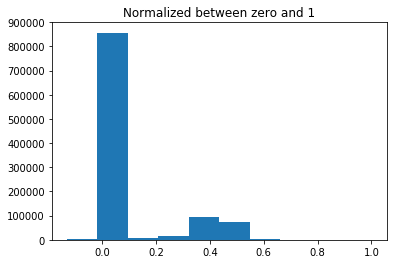

In [14]:
plt.figure()
plt.title("Normalized between zero and 1")
plt.hist(cis_data[4][0][0].flatten())
plt.show()

/home/fabiane/anaconda2/envs/postal/lib/python3.6/site-packages/ipykernel_launcher.py:16: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
  app.launch_new_instance()


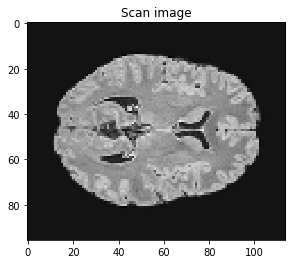

In [15]:
plt.figure()
plt.title("Scan image")
plt.imshow(np.squeeze(cis_data[4][0][0])[:,:,42], cmap='gray')
plt.show()

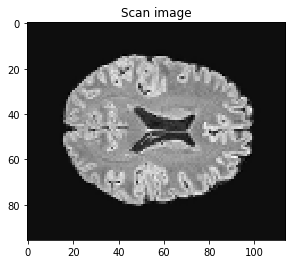

In [16]:
# TODO compare with healthy brain
plt.figure()
plt.title("Scan image")
plt.imshow(np.squeeze(X_train[15])[:,:,48], cmap='gray')
plt.show()

# Model

In [17]:
def init_model(path, finetune=True, up_to=7):
    model = load_model(path)
    model.load_weights(path)
    if finetune:
        for layer in model.layers[:up_to]:
            layer.trainable = False
    return model

In [18]:
# load model weights
#model_path = "/analysis/ritter/Dataset/models/fabi/ADNI/pretraining_paper/model.h5"
#model_path = "/analysis/ritter/Dataset/models/fabi/ADNI/pretraining_paper/model_trial_6.h5"
model_path = "/analysis/fabiane/models/ADNI/explMS/model_trial_6.h5"
model = init_model(model_path, finetune=False, up_to=None)
print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Conv_1 (Conv3D)              (None, 94, 112, 94, 64)   1792      
_________________________________________________________________
Pool_1 (MaxPooling3D)        (None, 31, 37, 31, 64)    0         
_________________________________________________________________
dropout_19 (Dropout)         (None, 31, 37, 31, 64)    0         
_________________________________________________________________
Conv_2 (Conv3D)              (None, 29, 35, 29, 64)    110656    
_________________________________________________________________
Pool_2 (MaxPooling3D)        (None, 9, 11, 9, 64)      0         
_________________________________________________________________
dropout_20 (Dropout)         (None, 9, 11, 9, 64)      0         
_________________________________________________________________
Conv_3 (Conv3D)              (None, 7, 9, 7, 64)       110656    
__________

## Visualization

In [19]:
def visualize_weights(model):
    # Visualize weights
    W = model.layers[0].get_weights()[0]
    W = np.squeeze(W)[:,:,2]
    print("W shape : ", W.shape)

    print("Weights mean {}".format(W.mean()))
    plt.figure(figsize=(20, 5))
    plt.title('conv1 weights')
    plt.imshow(make_mosaic(W, 2, 2), cmap="gray")
    plt.show()

In [20]:
import numpy.ma as ma
def make_mosaic(imgs, nrows, ncols, border=1):
    """
    Given a set of images with all the same shape, makes a
    mosaic with nrows and ncols
    """
    nimgs = imgs.shape[0]
    imshape = imgs.shape[1:]
    
    mosaic = ma.masked_all((nrows * imshape[0] + (nrows - 1) * border,
                            ncols * imshape[1] + (ncols - 1) * border),
                            dtype=np.float32)
    
    paddedh = imshape[0] + border
    paddedw = imshape[1] + border
    for i in range(nimgs):
        row = int(np.floor(i / ncols))
        col = i % ncols
        
        mosaic[row * paddedh:row * paddedh + imshape[0],
               col * paddedw:col * paddedw + imshape[1]] = imgs[i]
    return mosaic

In [21]:
def reset_weights(model):
    # Note this only used for visualization below
    session = K.get_session()
    for layer in model.layers: 
        if hasattr(layer, 'kernel_initializer'):
            layer.kernel.initializer.run(session=session)


Pre-trained model layer 1 weights:
W shape :  (3, 3, 64)
Weights mean -0.0010960017098113894


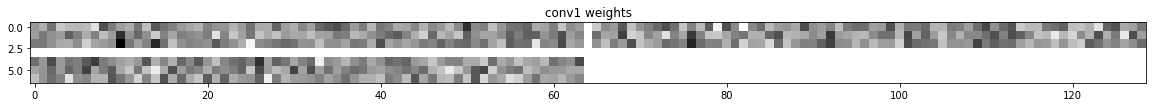

Random model layer 1 weights:
W shape :  (3, 3, 64)
Weights mean -0.00047259105485863984


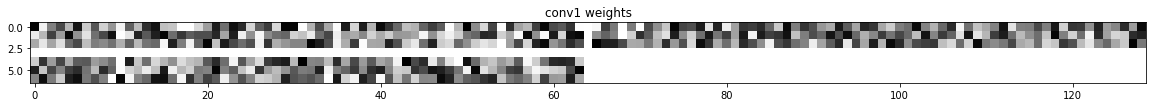

In [22]:
# Visualize weights
print("Pre-trained model layer 1 weights:")
visualize_weights(model)
model_untrained = load_model(model_path)
reset_weights(model_untrained)
print("Random model layer 1 weights:")
visualize_weights(model_untrained)

## Training

In [23]:
X_train.shape

(120, 96, 114, 96)

In [24]:
from sklearn.model_selection import train_test_split

In [25]:
# split training set
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.15, random_state=77)

Trial 0
Epoch 1/200


/home/fabiane/anaconda2/envs/postal/lib/python3.6/site-packages/ipykernel_launcher.py:16: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
  app.launch_new_instance()


26/26 [==============================] - 8s 298ms/step - loss: 1.0347 - acc: 0.6151 - val_loss: 1.0281 - val_acc: 0.3889

Epoch 00001: val_acc improved from -inf to 0.38889, saving model to /analysis/fabiane/models/MS/pretrained/rebuild_64Net/new_script/remove_lesions/valverde/weights-augm-trial0-improvement-BEST.hdf5
Epoch 2/200
26/26 [==============================] - 4s 153ms/step - loss: 0.9236 - acc: 0.5485 - val_loss: 0.9023 - val_acc: 0.3889

Epoch 00002: val_acc did not improve from 0.38889
Epoch 3/200
26/26 [==============================] - 4s 160ms/step - loss: 0.9546 - acc: 0.4523 - val_loss: 0.8566 - val_acc: 0.6111

Epoch 00003: val_acc improved from 0.38889 to 0.61111, saving model to /analysis/fabiane/models/MS/pretrained/rebuild_64Net/new_script/remove_lesions/valverde/weights-augm-trial0-improvement-BEST.hdf5
Epoch 4/200
26/26 [==============================] - 4s 153ms/step - loss: 0.9690 - acc: 0.5192 - val_loss: 0.8279 - val_acc: 0.6111

Epoch 00004: val_acc did no


Epoch 00040: val_acc did not improve from 0.83333
Epoch 41/200
26/26 [==============================] - 4s 152ms/step - loss: 0.6517 - acc: 0.6921 - val_loss: 0.6140 - val_acc: 0.7778

Epoch 00041: val_acc did not improve from 0.83333
Epoch 42/200
26/26 [==============================] - 4s 157ms/step - loss: 0.6670 - acc: 0.6924 - val_loss: 0.6323 - val_acc: 0.7778

Epoch 00042: val_acc did not improve from 0.83333
Epoch 43/200
26/26 [==============================] - 4s 150ms/step - loss: 0.6650 - acc: 0.6636 - val_loss: 0.6690 - val_acc: 0.6111

Epoch 00043: val_acc did not improve from 0.83333
Epoch 44/200
26/26 [==============================] - 4s 151ms/step - loss: 0.6159 - acc: 0.6828 - val_loss: 0.5740 - val_acc: 0.9444

Epoch 00044: val_acc improved from 0.83333 to 0.94444, saving model to /analysis/fabiane/models/MS/pretrained/rebuild_64Net/new_script/remove_lesions/valverde/weights-augm-trial0-improvement-BEST.hdf5
Epoch 45/200
26/26 [==============================] - 4s 1

26/26 [==============================] - 4s 156ms/step - loss: 0.3440 - acc: 0.9423 - val_loss: 0.4492 - val_acc: 0.8333

Epoch 00084: val_acc did not improve from 0.94444
Epoch 85/200
26/26 [==============================] - 4s 161ms/step - loss: 0.3151 - acc: 0.9519 - val_loss: 0.5671 - val_acc: 0.7778

Epoch 00085: val_acc did not improve from 0.94444
Epoch 86/200
26/26 [==============================] - 4s 160ms/step - loss: 0.3071 - acc: 0.9230 - val_loss: 0.3632 - val_acc: 0.9444

Epoch 00086: val_acc did not improve from 0.94444
Epoch 87/200
26/26 [==============================] - 4s 154ms/step - loss: 0.2921 - acc: 0.9615 - val_loss: 0.5051 - val_acc: 0.7778

Epoch 00087: val_acc did not improve from 0.94444
Epoch 88/200
26/26 [==============================] - 4s 159ms/step - loss: 0.2722 - acc: 0.9615 - val_loss: 0.3909 - val_acc: 0.9444

Epoch 00088: val_acc did not improve from 0.94444
Epoch 89/200
26/26 [==============================] - 4s 160ms/step - loss: 0.2787 - acc

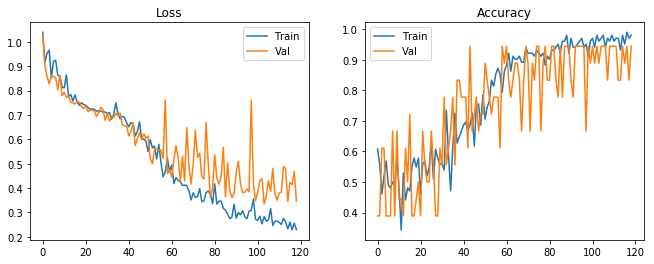

Trial 1
Epoch 1/200
26/26 [==============================] - 5s 195ms/step - loss: 1.1288 - acc: 0.5381 - val_loss: 0.8910 - val_acc: 0.6111

Epoch 00001: val_acc improved from -inf to 0.61111, saving model to /analysis/fabiane/models/MS/pretrained/rebuild_64Net/new_script/remove_lesions/valverde/weights-augm-trial1-improvement-BEST.hdf5
Epoch 2/200
26/26 [==============================] - 4s 154ms/step - loss: 1.0380 - acc: 0.4519 - val_loss: 0.9302 - val_acc: 0.3889

Epoch 00002: val_acc did not improve from 0.61111
Epoch 3/200
26/26 [==============================] - 4s 151ms/step - loss: 0.9885 - acc: 0.4708 - val_loss: 0.8221 - val_acc: 0.7778

Epoch 00003: val_acc improved from 0.61111 to 0.77778, saving model to /analysis/fabiane/models/MS/pretrained/rebuild_64Net/new_script/remove_lesions/valverde/weights-augm-trial1-improvement-BEST.hdf5
Epoch 4/200
26/26 [==============================] - 4s 155ms/step - loss: 0.9498 - acc: 0.5192 - val_loss: 0.8474 - val_acc: 0.5556

Epoch 0

26/26 [==============================] - 4s 154ms/step - loss: 0.5447 - acc: 0.7883 - val_loss: 0.4972 - val_acc: 0.8889

Epoch 00042: val_acc did not improve from 0.88889
Epoch 43/200
26/26 [==============================] - 4s 151ms/step - loss: 0.4897 - acc: 0.8460 - val_loss: 0.4997 - val_acc: 0.8333

Epoch 00043: val_acc did not improve from 0.88889
Epoch 44/200
26/26 [==============================] - 4s 151ms/step - loss: 0.4968 - acc: 0.8749 - val_loss: 0.4898 - val_acc: 0.8889

Epoch 00044: val_acc did not improve from 0.88889
Epoch 45/200
26/26 [==============================] - 4s 151ms/step - loss: 0.4557 - acc: 0.8849 - val_loss: 0.5110 - val_acc: 0.7778

Epoch 00045: val_acc did not improve from 0.88889
Epoch 46/200
26/26 [==============================] - 4s 155ms/step - loss: 0.4398 - acc: 0.8749 - val_loss: 0.4685 - val_acc: 0.7778

Epoch 00046: val_acc did not improve from 0.88889
Epoch 47/200
26/26 [==============================] - 4s 155ms/step - loss: 0.4452 - acc


Epoch 00085: val_acc did not improve from 0.94444
Epoch 86/200
26/26 [==============================] - 4s 153ms/step - loss: 0.3440 - acc: 0.9423 - val_loss: 0.4639 - val_acc: 0.8333

Epoch 00086: val_acc did not improve from 0.94444
Epoch 87/200
26/26 [==============================] - 4s 150ms/step - loss: 0.2667 - acc: 0.9808 - val_loss: 0.4735 - val_acc: 0.8333

Epoch 00087: val_acc did not improve from 0.94444
Epoch 88/200
26/26 [==============================] - 4s 156ms/step - loss: 0.2498 - acc: 0.9711 - val_loss: 0.4624 - val_acc: 0.8333

Epoch 00088: val_acc did not improve from 0.94444
Epoch 00088: early stopping


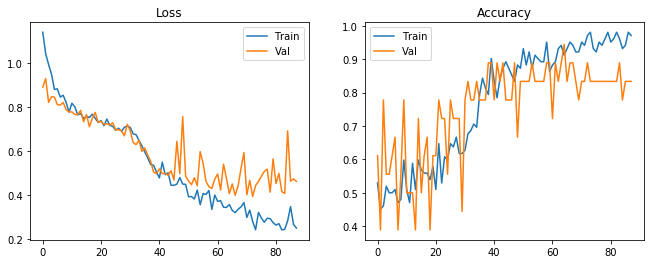

Trial 2
Epoch 1/200
26/26 [==============================] - 5s 208ms/step - loss: 1.0266 - acc: 0.5189 - val_loss: 0.8877 - val_acc: 0.6111

Epoch 00001: val_acc improved from -inf to 0.61111, saving model to /analysis/fabiane/models/MS/pretrained/rebuild_64Net/new_script/remove_lesions/valverde/weights-augm-trial2-improvement-BEST.hdf5
Epoch 2/200
26/26 [==============================] - 4s 152ms/step - loss: 1.0260 - acc: 0.4904 - val_loss: 1.0315 - val_acc: 0.3889

Epoch 00002: val_acc did not improve from 0.61111
Epoch 3/200
26/26 [==============================] - 4s 153ms/step - loss: 0.9966 - acc: 0.3845 - val_loss: 0.8559 - val_acc: 0.6111

Epoch 00003: val_acc did not improve from 0.61111
Epoch 4/200
26/26 [==============================] - 4s 153ms/step - loss: 0.9176 - acc: 0.5385 - val_loss: 0.8779 - val_acc: 0.3889

Epoch 00004: val_acc did not improve from 0.61111
Epoch 5/200
26/26 [==============================] - 4s 152ms/step - loss: 0.9189 - acc: 0.3942 - val_loss: 

26/26 [==============================] - 4s 159ms/step - loss: 0.5698 - acc: 0.7883 - val_loss: 0.5858 - val_acc: 0.6667

Epoch 00041: val_acc did not improve from 0.88889
Epoch 42/200
26/26 [==============================] - 4s 151ms/step - loss: 0.5250 - acc: 0.8460 - val_loss: 0.4806 - val_acc: 0.8889

Epoch 00042: val_acc did not improve from 0.88889
Epoch 43/200
26/26 [==============================] - 4s 161ms/step - loss: 0.5035 - acc: 0.8364 - val_loss: 0.4633 - val_acc: 0.8889

Epoch 00043: val_acc did not improve from 0.88889
Epoch 44/200
26/26 [==============================] - 4s 157ms/step - loss: 0.5235 - acc: 0.7887 - val_loss: 0.6036 - val_acc: 0.7222

Epoch 00044: val_acc did not improve from 0.88889
Epoch 45/200
26/26 [==============================] - 4s 163ms/step - loss: 0.5519 - acc: 0.8175 - val_loss: 0.4211 - val_acc: 0.9444

Epoch 00045: val_acc improved from 0.88889 to 0.94444, saving model to /analysis/fabiane/models/MS/pretrained/rebuild_64Net/new_script/rem


Epoch 00084: val_acc did not improve from 0.94444
Epoch 85/200
26/26 [==============================] - 4s 159ms/step - loss: 0.2305 - acc: 0.9711 - val_loss: 0.4731 - val_acc: 0.8333

Epoch 00085: val_acc did not improve from 0.94444
Epoch 86/200
26/26 [==============================] - 4s 163ms/step - loss: 0.2866 - acc: 0.9426 - val_loss: 0.3248 - val_acc: 0.9444

Epoch 00086: val_acc did not improve from 0.94444
Epoch 87/200
26/26 [==============================] - 4s 153ms/step - loss: 0.2764 - acc: 0.9519 - val_loss: 0.3671 - val_acc: 0.8889

Epoch 00087: val_acc did not improve from 0.94444
Epoch 88/200
26/26 [==============================] - 4s 158ms/step - loss: 0.2513 - acc: 0.9615 - val_loss: 0.6144 - val_acc: 0.8333

Epoch 00088: val_acc did not improve from 0.94444
Epoch 89/200
26/26 [==============================] - 4s 161ms/step - loss: 0.2508 - acc: 0.9615 - val_loss: 0.3921 - val_acc: 0.8889

Epoch 00089: val_acc did not improve from 0.94444
Epoch 90/200
26/26 [====

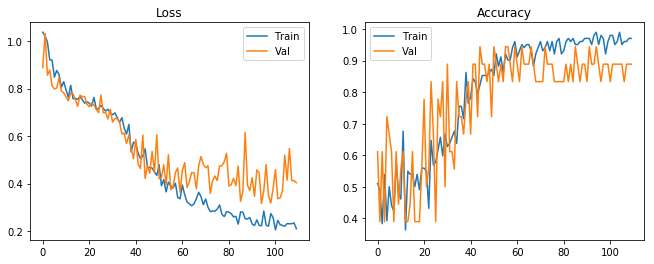

Trial 3
Epoch 1/200
26/26 [==============================] - 5s 205ms/step - loss: 1.1291 - acc: 0.4138 - val_loss: 1.0138 - val_acc: 0.3889

Epoch 00001: val_acc improved from -inf to 0.38889, saving model to /analysis/fabiane/models/MS/pretrained/rebuild_64Net/new_script/remove_lesions/valverde/weights-augm-trial3-improvement-BEST.hdf5
Epoch 2/200
26/26 [==============================] - 4s 152ms/step - loss: 0.9842 - acc: 0.4996 - val_loss: 0.8966 - val_acc: 0.4444

Epoch 00002: val_acc improved from 0.38889 to 0.44444, saving model to /analysis/fabiane/models/MS/pretrained/rebuild_64Net/new_script/remove_lesions/valverde/weights-augm-trial3-improvement-BEST.hdf5
Epoch 3/200
26/26 [==============================] - 4s 152ms/step - loss: 0.9104 - acc: 0.5477 - val_loss: 0.8705 - val_acc: 0.7778

Epoch 00003: val_acc improved from 0.44444 to 0.77778, saving model to /analysis/fabiane/models/MS/pretrained/rebuild_64Net/new_script/remove_lesions/valverde/weights-augm-trial3-improvement-

26/26 [==============================] - 4s 159ms/step - loss: 0.5540 - acc: 0.8175 - val_loss: 0.4685 - val_acc: 0.8889

Epoch 00042: val_acc did not improve from 0.94444
Epoch 43/200
26/26 [==============================] - 4s 161ms/step - loss: 0.5256 - acc: 0.8364 - val_loss: 0.4344 - val_acc: 0.9444

Epoch 00043: val_acc did not improve from 0.94444
Epoch 44/200
26/26 [==============================] - 4s 154ms/step - loss: 0.4881 - acc: 0.8268 - val_loss: 0.5052 - val_acc: 0.8333

Epoch 00044: val_acc did not improve from 0.94444
Epoch 45/200
26/26 [==============================] - 4s 157ms/step - loss: 0.4740 - acc: 0.8560 - val_loss: 0.5788 - val_acc: 0.7222

Epoch 00045: val_acc did not improve from 0.94444
Epoch 46/200
26/26 [==============================] - 4s 156ms/step - loss: 0.5148 - acc: 0.8175 - val_loss: 0.4377 - val_acc: 0.9444

Epoch 00046: val_acc did not improve from 0.94444
Epoch 47/200
26/26 [==============================] - 4s 160ms/step - loss: 0.4599 - acc


Epoch 00085: val_acc did not improve from 1.00000
Epoch 86/200
26/26 [==============================] - 4s 160ms/step - loss: 0.2825 - acc: 0.9519 - val_loss: 0.3966 - val_acc: 0.8889

Epoch 00086: val_acc did not improve from 1.00000
Epoch 87/200
26/26 [==============================] - 4s 158ms/step - loss: 0.2867 - acc: 0.9519 - val_loss: 0.3118 - val_acc: 0.9444

Epoch 00087: val_acc did not improve from 1.00000
Epoch 88/200
26/26 [==============================] - 4s 159ms/step - loss: 0.2880 - acc: 0.9519 - val_loss: 0.3379 - val_acc: 0.9444

Epoch 00088: val_acc did not improve from 1.00000
Epoch 89/200
26/26 [==============================] - 4s 158ms/step - loss: 0.2937 - acc: 0.9519 - val_loss: 0.4178 - val_acc: 0.8333

Epoch 00089: val_acc did not improve from 1.00000
Epoch 90/200
26/26 [==============================] - 4s 154ms/step - loss: 0.2690 - acc: 0.9423 - val_loss: 0.4578 - val_acc: 0.8333

Epoch 00090: val_acc did not improve from 1.00000
Epoch 91/200
26/26 [====

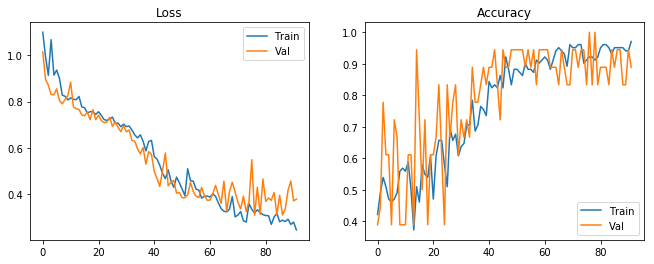

Trial 4
Epoch 1/200
26/26 [==============================] - 6s 219ms/step - loss: 1.0428 - acc: 0.5189 - val_loss: 0.9552 - val_acc: 0.3889

Epoch 00001: val_acc improved from -inf to 0.38889, saving model to /analysis/fabiane/models/MS/pretrained/rebuild_64Net/new_script/remove_lesions/valverde/weights-augm-trial4-improvement-BEST.hdf5
Epoch 2/200
26/26 [==============================] - 4s 155ms/step - loss: 0.9348 - acc: 0.5577 - val_loss: 0.8767 - val_acc: 0.6111

Epoch 00002: val_acc improved from 0.38889 to 0.61111, saving model to /analysis/fabiane/models/MS/pretrained/rebuild_64Net/new_script/remove_lesions/valverde/weights-augm-trial4-improvement-BEST.hdf5
Epoch 3/200
26/26 [==============================] - 4s 155ms/step - loss: 0.9928 - acc: 0.4330 - val_loss: 0.8885 - val_acc: 0.3889

Epoch 00003: val_acc did not improve from 0.61111
Epoch 4/200
26/26 [==============================] - 4s 158ms/step - loss: 0.8966 - acc: 0.5093 - val_loss: 0.8722 - val_acc: 0.3889

Epoch 0

26/26 [==============================] - 4s 154ms/step - loss: 0.5184 - acc: 0.8079 - val_loss: 0.7541 - val_acc: 0.5000

Epoch 00043: val_acc did not improve from 0.83333
Epoch 44/200
26/26 [==============================] - 4s 163ms/step - loss: 0.5372 - acc: 0.8460 - val_loss: 0.5181 - val_acc: 0.8333

Epoch 00044: val_acc did not improve from 0.83333
Epoch 45/200
26/26 [==============================] - 4s 161ms/step - loss: 0.5114 - acc: 0.8368 - val_loss: 0.4999 - val_acc: 0.8889

Epoch 00045: val_acc improved from 0.83333 to 0.88889, saving model to /analysis/fabiane/models/MS/pretrained/rebuild_64Net/new_script/remove_lesions/valverde/weights-augm-trial4-improvement-BEST.hdf5
Epoch 46/200
26/26 [==============================] - 4s 151ms/step - loss: 0.5142 - acc: 0.8268 - val_loss: 0.5362 - val_acc: 0.7778

Epoch 00046: val_acc did not improve from 0.88889
Epoch 47/200
26/26 [==============================] - 4s 160ms/step - loss: 0.5141 - acc: 0.7887 - val_loss: 0.5004 - val_


Epoch 00085: val_acc did not improve from 0.94444
Epoch 86/200
26/26 [==============================] - 4s 161ms/step - loss: 0.2684 - acc: 0.9615 - val_loss: 0.4475 - val_acc: 0.8333

Epoch 00086: val_acc did not improve from 0.94444
Epoch 87/200
26/26 [==============================] - 4s 160ms/step - loss: 0.2988 - acc: 0.9330 - val_loss: 0.3401 - val_acc: 0.8889

Epoch 00087: val_acc did not improve from 0.94444
Epoch 88/200
26/26 [==============================] - 4s 164ms/step - loss: 0.2848 - acc: 0.9326 - val_loss: 0.5665 - val_acc: 0.8333

Epoch 00088: val_acc did not improve from 0.94444
Epoch 89/200
26/26 [==============================] - 4s 156ms/step - loss: 0.2731 - acc: 0.9711 - val_loss: 0.4566 - val_acc: 0.8333

Epoch 00089: val_acc did not improve from 0.94444
Epoch 90/200
26/26 [==============================] - 4s 162ms/step - loss: 0.2532 - acc: 0.9711 - val_loss: 0.3910 - val_acc: 0.8889

Epoch 00090: val_acc did not improve from 0.94444
Epoch 91/200
26/26 [====

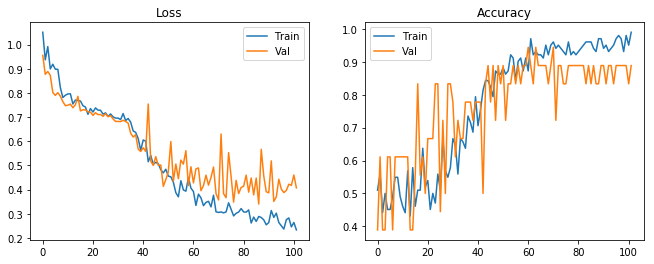

Trial 5
Epoch 1/200
26/26 [==============================] - 6s 218ms/step - loss: 1.1328 - acc: 0.5096 - val_loss: 0.8941 - val_acc: 0.6111

Epoch 00001: val_acc improved from -inf to 0.61111, saving model to /analysis/fabiane/models/MS/pretrained/rebuild_64Net/new_script/remove_lesions/valverde/weights-augm-trial5-improvement-BEST.hdf5
Epoch 2/200
26/26 [==============================] - 4s 154ms/step - loss: 0.9463 - acc: 0.5100 - val_loss: 1.0089 - val_acc: 0.3889

Epoch 00002: val_acc did not improve from 0.61111
Epoch 3/200
26/26 [==============================] - 4s 154ms/step - loss: 1.0482 - acc: 0.3845 - val_loss: 0.8575 - val_acc: 0.5000

Epoch 00003: val_acc did not improve from 0.61111
Epoch 4/200
26/26 [==============================] - 4s 152ms/step - loss: 0.8924 - acc: 0.4804 - val_loss: 1.0038 - val_acc: 0.3889

Epoch 00004: val_acc did not improve from 0.61111
Epoch 5/200
26/26 [==============================] - 4s 155ms/step - loss: 0.9820 - acc: 0.5000 - val_loss: 

26/26 [==============================] - 4s 153ms/step - loss: 0.5122 - acc: 0.8268 - val_loss: 0.5330 - val_acc: 0.8333

Epoch 00041: val_acc did not improve from 0.94444
Epoch 42/200
26/26 [==============================] - 4s 158ms/step - loss: 0.4764 - acc: 0.8557 - val_loss: 0.4502 - val_acc: 0.8889

Epoch 00042: val_acc did not improve from 0.94444
Epoch 43/200
26/26 [==============================] - 4s 154ms/step - loss: 0.5090 - acc: 0.8268 - val_loss: 0.4703 - val_acc: 0.9444

Epoch 00043: val_acc did not improve from 0.94444
Epoch 44/200
26/26 [==============================] - 4s 155ms/step - loss: 0.5446 - acc: 0.7790 - val_loss: 0.7572 - val_acc: 0.5556

Epoch 00044: val_acc did not improve from 0.94444
Epoch 45/200
26/26 [==============================] - 4s 160ms/step - loss: 0.4891 - acc: 0.8364 - val_loss: 0.5446 - val_acc: 0.8333

Epoch 00045: val_acc did not improve from 0.94444
Epoch 46/200
26/26 [==============================] - 4s 159ms/step - loss: 0.4247 - acc

26/26 [==============================] - 4s 151ms/step - loss: 0.2955 - acc: 0.9519 - val_loss: 0.3231 - val_acc: 0.8889

Epoch 00085: val_acc did not improve from 0.94444
Epoch 86/200
26/26 [==============================] - 4s 155ms/step - loss: 0.3114 - acc: 0.9326 - val_loss: 0.3034 - val_acc: 0.9444

Epoch 00086: val_acc did not improve from 0.94444
Epoch 87/200
26/26 [==============================] - 4s 158ms/step - loss: 0.2844 - acc: 0.9615 - val_loss: 0.3589 - val_acc: 0.9444

Epoch 00087: val_acc did not improve from 0.94444
Epoch 88/200
26/26 [==============================] - 4s 159ms/step - loss: 0.2453 - acc: 0.9615 - val_loss: 0.3884 - val_acc: 0.8889

Epoch 00088: val_acc did not improve from 0.94444
Epoch 89/200
26/26 [==============================] - 4s 161ms/step - loss: 0.2166 - acc: 0.9711 - val_loss: 0.4970 - val_acc: 0.8333

Epoch 00089: val_acc did not improve from 0.94444
Epoch 90/200
26/26 [==============================] - 4s 161ms/step - loss: 0.2867 - acc

26/26 [==============================] - 4s 161ms/step - loss: 0.1921 - acc: 0.9904 - val_loss: 0.3814 - val_acc: 0.8333

Epoch 00129: val_acc did not improve from 0.94444
Epoch 130/200
26/26 [==============================] - 4s 163ms/step - loss: 0.1989 - acc: 0.9808 - val_loss: 0.3390 - val_acc: 0.8889

Epoch 00130: val_acc did not improve from 0.94444
Epoch 00130: early stopping


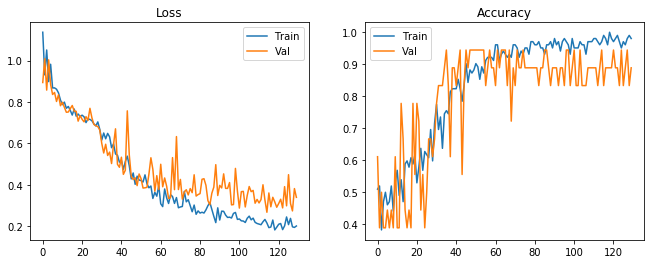

Trial 6
Epoch 1/200
26/26 [==============================] - 6s 231ms/step - loss: 1.0223 - acc: 0.5100 - val_loss: 0.9115 - val_acc: 0.3889

Epoch 00001: val_acc improved from -inf to 0.38889, saving model to /analysis/fabiane/models/MS/pretrained/rebuild_64Net/new_script/remove_lesions/valverde/weights-augm-trial6-improvement-BEST.hdf5
Epoch 2/200
26/26 [==============================] - 4s 155ms/step - loss: 0.9714 - acc: 0.5004 - val_loss: 0.8655 - val_acc: 0.6111

Epoch 00002: val_acc improved from 0.38889 to 0.61111, saving model to /analysis/fabiane/models/MS/pretrained/rebuild_64Net/new_script/remove_lesions/valverde/weights-augm-trial6-improvement-BEST.hdf5
Epoch 3/200
26/26 [==============================] - 4s 159ms/step - loss: 0.8950 - acc: 0.5577 - val_loss: 0.9302 - val_acc: 0.3889

Epoch 00003: val_acc did not improve from 0.61111
Epoch 4/200
26/26 [==============================] - 4s 161ms/step - loss: 0.8950 - acc: 0.5289 - val_loss: 0.8301 - val_acc: 0.6111

Epoch 0

26/26 [==============================] - 4s 163ms/step - loss: 0.5520 - acc: 0.8172 - val_loss: 0.5788 - val_acc: 0.7778

Epoch 00039: val_acc did not improve from 0.94444
Epoch 40/200
26/26 [==============================] - 4s 165ms/step - loss: 0.5005 - acc: 0.8753 - val_loss: 0.5158 - val_acc: 0.8333

Epoch 00040: val_acc did not improve from 0.94444
Epoch 41/200
26/26 [==============================] - 4s 162ms/step - loss: 0.4420 - acc: 0.8557 - val_loss: 0.4241 - val_acc: 0.9444

Epoch 00041: val_acc did not improve from 0.94444
Epoch 42/200
26/26 [==============================] - 4s 152ms/step - loss: 0.4595 - acc: 0.8653 - val_loss: 0.4485 - val_acc: 1.0000

Epoch 00042: val_acc improved from 0.94444 to 1.00000, saving model to /analysis/fabiane/models/MS/pretrained/rebuild_64Net/new_script/remove_lesions/valverde/weights-augm-trial6-improvement-BEST.hdf5
Epoch 43/200
26/26 [==============================] - 4s 155ms/step - loss: 0.5011 - acc: 0.8268 - val_loss: 0.4243 - val_

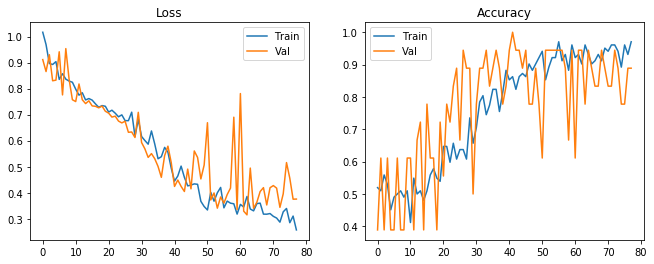

Trial 7
Epoch 1/200
26/26 [==============================] - 6s 236ms/step - loss: 0.9959 - acc: 0.5381 - val_loss: 0.8814 - val_acc: 0.6111

Epoch 00001: val_acc improved from -inf to 0.61111, saving model to /analysis/fabiane/models/MS/pretrained/rebuild_64Net/new_script/remove_lesions/valverde/weights-augm-trial7-improvement-BEST.hdf5
Epoch 2/200
26/26 [==============================] - 4s 160ms/step - loss: 0.9834 - acc: 0.4900 - val_loss: 0.8573 - val_acc: 0.6111

Epoch 00002: val_acc did not improve from 0.61111
Epoch 3/200
26/26 [==============================] - 4s 157ms/step - loss: 0.9035 - acc: 0.5004 - val_loss: 0.8740 - val_acc: 0.3889

Epoch 00003: val_acc did not improve from 0.61111
Epoch 4/200
26/26 [==============================] - 4s 155ms/step - loss: 0.8479 - acc: 0.5289 - val_loss: 0.8261 - val_acc: 0.3889

Epoch 00004: val_acc did not improve from 0.61111
Epoch 5/200
26/26 [==============================] - 4s 156ms/step - loss: 0.8617 - acc: 0.4615 - val_loss: 

26/26 [==============================] - 4s 151ms/step - loss: 0.5470 - acc: 0.7887 - val_loss: 0.5118 - val_acc: 0.8333

Epoch 00042: val_acc did not improve from 0.88889
Epoch 43/200
26/26 [==============================] - 4s 150ms/step - loss: 0.5180 - acc: 0.8076 - val_loss: 0.4507 - val_acc: 0.8889

Epoch 00043: val_acc did not improve from 0.88889
Epoch 44/200
26/26 [==============================] - 4s 151ms/step - loss: 0.5584 - acc: 0.7790 - val_loss: 0.4319 - val_acc: 0.8889

Epoch 00044: val_acc did not improve from 0.88889
Epoch 45/200
26/26 [==============================] - 4s 151ms/step - loss: 0.4994 - acc: 0.8268 - val_loss: 0.4612 - val_acc: 0.8889

Epoch 00045: val_acc did not improve from 0.88889
Epoch 46/200
26/26 [==============================] - 4s 150ms/step - loss: 0.4874 - acc: 0.8175 - val_loss: 0.4129 - val_acc: 0.8889

Epoch 00046: val_acc did not improve from 0.88889
Epoch 47/200
26/26 [==============================] - 4s 152ms/step - loss: 0.4543 - acc


Epoch 00085: val_acc did not improve from 0.94444
Epoch 86/200
26/26 [==============================] - 4s 153ms/step - loss: 0.2784 - acc: 0.9519 - val_loss: 0.3455 - val_acc: 0.8333

Epoch 00086: val_acc did not improve from 0.94444
Epoch 87/200
26/26 [==============================] - 4s 158ms/step - loss: 0.3554 - acc: 0.9045 - val_loss: 0.4991 - val_acc: 0.8333

Epoch 00087: val_acc did not improve from 0.94444
Epoch 88/200
26/26 [==============================] - 4s 160ms/step - loss: 0.2778 - acc: 0.9615 - val_loss: 0.3818 - val_acc: 0.8889

Epoch 00088: val_acc did not improve from 0.94444
Epoch 89/200
26/26 [==============================] - 4s 158ms/step - loss: 0.2524 - acc: 0.9808 - val_loss: 0.4912 - val_acc: 0.8333

Epoch 00089: val_acc did not improve from 0.94444
Epoch 90/200
26/26 [==============================] - 4s 169ms/step - loss: 0.2507 - acc: 0.9711 - val_loss: 0.3209 - val_acc: 0.9444

Epoch 00090: val_acc did not improve from 0.94444
Epoch 91/200
26/26 [====

26/26 [==============================] - 4s 164ms/step - loss: 0.1795 - acc: 0.9904 - val_loss: 0.4663 - val_acc: 0.8333

Epoch 00130: val_acc did not improve from 0.94444
Epoch 131/200
26/26 [==============================] - 4s 153ms/step - loss: 0.2080 - acc: 0.9615 - val_loss: 0.3024 - val_acc: 0.9444

Epoch 00131: val_acc did not improve from 0.94444
Epoch 132/200
26/26 [==============================] - 4s 162ms/step - loss: 0.2127 - acc: 0.9808 - val_loss: 0.3023 - val_acc: 0.9444

Epoch 00132: val_acc did not improve from 0.94444
Epoch 133/200
26/26 [==============================] - 4s 161ms/step - loss: 0.1937 - acc: 0.9904 - val_loss: 0.3777 - val_acc: 0.8889

Epoch 00133: val_acc did not improve from 0.94444
Epoch 134/200
26/26 [==============================] - 4s 155ms/step - loss: 0.1816 - acc: 0.9904 - val_loss: 0.3620 - val_acc: 0.8889

Epoch 00134: val_acc did not improve from 0.94444
Epoch 135/200
26/26 [==============================] - 4s 162ms/step - loss: 0.1825 

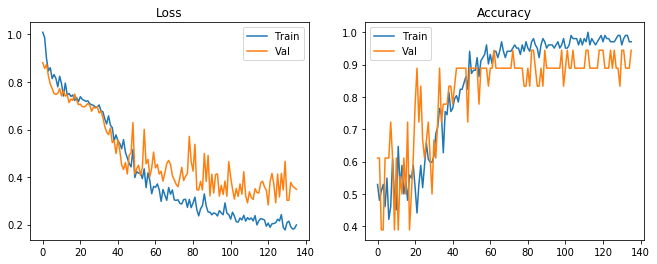

Trial 8
Epoch 1/200
26/26 [==============================] - 6s 228ms/step - loss: 1.0008 - acc: 0.5477 - val_loss: 0.9167 - val_acc: 0.5000

Epoch 00001: val_acc improved from -inf to 0.50000, saving model to /analysis/fabiane/models/MS/pretrained/rebuild_64Net/new_script/remove_lesions/valverde/weights-augm-trial8-improvement-BEST.hdf5
Epoch 2/200
26/26 [==============================] - 4s 155ms/step - loss: 0.9753 - acc: 0.5093 - val_loss: 0.8910 - val_acc: 0.5000

Epoch 00002: val_acc did not improve from 0.50000
Epoch 3/200
26/26 [==============================] - 4s 162ms/step - loss: 0.9003 - acc: 0.5000 - val_loss: 0.8582 - val_acc: 0.3889

Epoch 00003: val_acc did not improve from 0.50000
Epoch 4/200
26/26 [==============================] - 4s 154ms/step - loss: 0.9325 - acc: 0.4419 - val_loss: 0.8355 - val_acc: 0.5000

Epoch 00004: val_acc did not improve from 0.50000
Epoch 5/200
26/26 [==============================] - 4s 159ms/step - loss: 0.8957 - acc: 0.5100 - val_loss: 

26/26 [==============================] - 4s 162ms/step - loss: 0.5657 - acc: 0.8368 - val_loss: 0.4524 - val_acc: 0.9444

Epoch 00041: val_acc improved from 0.88889 to 0.94444, saving model to /analysis/fabiane/models/MS/pretrained/rebuild_64Net/new_script/remove_lesions/valverde/weights-augm-trial8-improvement-BEST.hdf5
Epoch 42/200
26/26 [==============================] - 4s 157ms/step - loss: 0.4063 - acc: 0.9138 - val_loss: 0.4372 - val_acc: 0.8889

Epoch 00042: val_acc did not improve from 0.94444
Epoch 43/200
26/26 [==============================] - 4s 158ms/step - loss: 0.4889 - acc: 0.8364 - val_loss: 0.4386 - val_acc: 0.9444

Epoch 00043: val_acc did not improve from 0.94444
Epoch 44/200
26/26 [==============================] - 4s 155ms/step - loss: 0.4156 - acc: 0.8945 - val_loss: 0.4204 - val_acc: 0.8889

Epoch 00044: val_acc did not improve from 0.94444
Epoch 45/200
26/26 [==============================] - 4s 163ms/step - loss: 0.4903 - acc: 0.8364 - val_loss: 0.4143 - val_


Epoch 00083: val_acc did not improve from 1.00000
Epoch 84/200
26/26 [==============================] - 4s 163ms/step - loss: 0.2688 - acc: 0.9615 - val_loss: 0.3504 - val_acc: 0.8889

Epoch 00084: val_acc did not improve from 1.00000
Epoch 85/200
26/26 [==============================] - 4s 157ms/step - loss: 0.2560 - acc: 0.9519 - val_loss: 0.3682 - val_acc: 0.8889

Epoch 00085: val_acc did not improve from 1.00000
Epoch 86/200
26/26 [==============================] - 4s 155ms/step - loss: 0.2493 - acc: 0.9615 - val_loss: 0.3129 - val_acc: 0.9444

Epoch 00086: val_acc did not improve from 1.00000
Epoch 87/200
26/26 [==============================] - 4s 155ms/step - loss: 0.2741 - acc: 0.9326 - val_loss: 0.2878 - val_acc: 1.0000

Epoch 00087: val_acc did not improve from 1.00000
Epoch 88/200
26/26 [==============================] - 4s 160ms/step - loss: 0.2499 - acc: 0.9615 - val_loss: 0.3230 - val_acc: 0.9444

Epoch 00088: val_acc did not improve from 1.00000
Epoch 89/200
26/26 [====

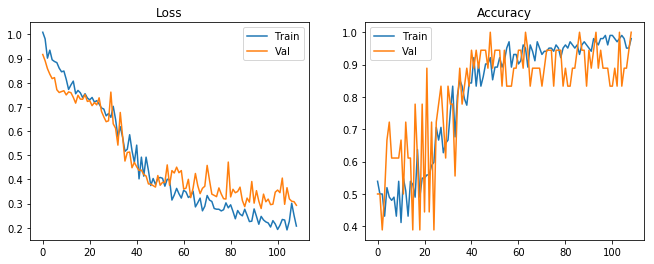

Trial 9
Epoch 1/200
26/26 [==============================] - 7s 253ms/step - loss: 1.0280 - acc: 0.5381 - val_loss: 0.8988 - val_acc: 0.6111

Epoch 00001: val_acc improved from -inf to 0.61111, saving model to /analysis/fabiane/models/MS/pretrained/rebuild_64Net/new_script/remove_lesions/valverde/weights-augm-trial9-improvement-BEST.hdf5
Epoch 2/200
26/26 [==============================] - 4s 155ms/step - loss: 0.9990 - acc: 0.4419 - val_loss: 0.8905 - val_acc: 0.5000

Epoch 00002: val_acc did not improve from 0.61111
Epoch 3/200
26/26 [==============================] - 4s 156ms/step - loss: 0.9424 - acc: 0.5196 - val_loss: 0.8632 - val_acc: 0.5556

Epoch 00003: val_acc did not improve from 0.61111
Epoch 4/200
26/26 [==============================] - 4s 159ms/step - loss: 0.9295 - acc: 0.5385 - val_loss: 0.9578 - val_acc: 0.3889

Epoch 00004: val_acc did not improve from 0.61111
Epoch 5/200
26/26 [==============================] - 4s 157ms/step - loss: 0.9613 - acc: 0.4041 - val_loss: 

26/26 [==============================] - 4s 158ms/step - loss: 0.4776 - acc: 0.8942 - val_loss: 0.4994 - val_acc: 0.7222

Epoch 00041: val_acc did not improve from 0.94444
Epoch 42/200
26/26 [==============================] - 4s 152ms/step - loss: 0.4874 - acc: 0.8371 - val_loss: 0.5110 - val_acc: 0.8333

Epoch 00042: val_acc did not improve from 0.94444
Epoch 43/200
26/26 [==============================] - 4s 158ms/step - loss: 0.4464 - acc: 0.8464 - val_loss: 0.6395 - val_acc: 0.7222

Epoch 00043: val_acc did not improve from 0.94444
Epoch 44/200
26/26 [==============================] - 4s 162ms/step - loss: 0.5140 - acc: 0.8653 - val_loss: 0.5069 - val_acc: 0.8333

Epoch 00044: val_acc did not improve from 0.94444
Epoch 45/200
26/26 [==============================] - 4s 153ms/step - loss: 0.3826 - acc: 0.9230 - val_loss: 0.4309 - val_acc: 0.8889

Epoch 00045: val_acc did not improve from 0.94444
Epoch 46/200
26/26 [==============================] - 4s 159ms/step - loss: 0.4563 - acc

26/26 [==============================] - 4s 152ms/step - loss: 0.2452 - acc: 0.9711 - val_loss: 0.3286 - val_acc: 0.9444

Epoch 00085: val_acc did not improve from 0.94444
Epoch 86/200
26/26 [==============================] - 4s 161ms/step - loss: 0.2444 - acc: 0.9904 - val_loss: 0.4201 - val_acc: 0.8889

Epoch 00086: val_acc did not improve from 0.94444
Epoch 87/200
26/26 [==============================] - 4s 155ms/step - loss: 0.2122 - acc: 0.9904 - val_loss: 0.4184 - val_acc: 0.8889

Epoch 00087: val_acc did not improve from 0.94444
Epoch 88/200
26/26 [==============================] - 4s 161ms/step - loss: 0.2238 - acc: 0.9808 - val_loss: 0.5981 - val_acc: 0.7778

Epoch 00088: val_acc did not improve from 0.94444
Epoch 89/200
26/26 [==============================] - 4s 155ms/step - loss: 0.2427 - acc: 0.9519 - val_loss: 0.3428 - val_acc: 0.9444

Epoch 00089: val_acc did not improve from 0.94444
Epoch 90/200
26/26 [==============================] - 4s 154ms/step - loss: 0.2197 - acc

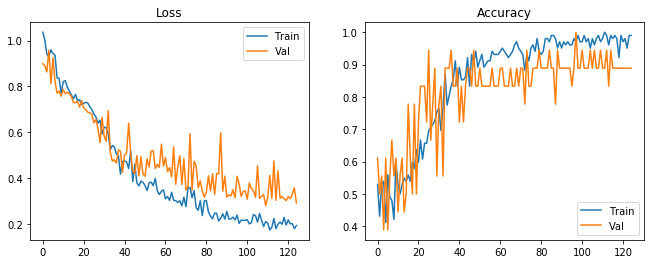

Training Time: 1.0h:16.0m:19.661869287490845s
Validation final accuracies: 
 [0.9444444444444444, 0.8333333333333334, 0.8888888888888888, 0.8888888888888888, 0.8888888888888888, 0.8888888888888888, 0.8888888888888888, 0.9444444444444444, 1.0, 0.8888888888888888]
Validation final accuracies mean: 0.9055555555555556
Validation best accuracies: 
 [0.9444444444444444, 0.9444444444444444, 0.9444444444444444, 1.0, 0.9444444444444444, 0.9444444444444444, 1.0, 0.9444444444444444, 1.0, 1.0]
Validation best accuracies mean: 0.9666666666666666
Validation balanced accuracies: 
 [0.9545454545454546, 0.8636363636363636, 0.9090909090909092, 0.9090909090909092, 0.9090909090909092, 0.9090909090909092, 0.9090909090909092, 0.9545454545454546, 1.0, 0.9090909090909092]
Validation balanced accuracies mean: 0.9227272727272726
Validation final sensitivities: 
 [0.9090909090909091, 0.7272727272727273, 0.8181818181818182, 0.8181818181818182, 0.8181818181818182, 0.8181818181818182, 0.8181818181818182, 0.90909090

In [26]:
# training args
lr = 0.0008
lr_decay = 0.002
transforms = [intensity, sagittal_flip, translate]

num_trials = 10
store_models = True

# callbacks
earlystop = EarlyStopping(monitor='val_loss', min_delta=0, patience=5, verbose=1, mode='auto')

accuracies = []
balanced_accuracies = []
sensitivities = []
specificities = []
max_acc = []

for i in range(num_trials):
    print("Trial %i" %i)
    
    # init model
    model = init_model(model_path, finetune=False, up_to=None)    
    opti = Adam(lr=lr, decay=lr_decay)
    model.compile(optimizer=opti, loss='binary_crossentropy', metrics=['accuracy'])
    
    # callbacks
    earlystop = EarlyStopping(monitor='val_loss', min_delta=0, patience=15, verbose=1, mode='auto')
    if store_models:
        result_path = os.path.join(result_dir, "weights-augm-trial%i-improvement-BEST.hdf5" %i)
        model_checkpoint = ModelCheckpoint(result_path, monitor='val_acc', verbose=1, save_best_only=True, mode='max', save_weights_only=True)
        callbacks = [earlystop, model_checkpoint]
    else:
        callbacks = [earlystop]
        
    train_loader = CISDataset(X_train, y_train, transform=transforms, batch_size=b, shuffle=True)
    val_loader = CISDataset(X_val, y_val, transform=[intensity], batch_size=1, shuffle=False)
    
    # Start training
    history = model.fit_generator(train_loader,
                        epochs=num_epochs,
                        verbose=1,
                        validation_data=val_loader,
                        callbacks=callbacks)
    # Plot training curves
    plt.figure(figsize=(11, 4))
    plt.subplot(1, 2, 1)
    plt.plot(history.history["loss"])
    plt.plot(history.history["val_loss"])
    plt.legend(["Train", "Val"])
    plt.title("Loss")
    plt.subplot(1, 2, 2)
    plt.plot(history.history["acc"])
    plt.plot(history.history["val_acc"])
    plt.legend(["Train", "Val"])
    plt.title("Accuracy")
    plt.show()
    # Evaluation
    y_pred = model.predict_generator(val_loader)
    #y_true = [item for sublist in [val_loader[batch_idx][1] for batch_idx in range(len(val_loader))] for item in sublist]
    bal_acc = balanced_accuracy(y_val, y_pred>0.5)
    sens = sensitivity(y_val, y_pred>0.5)
    spec = specificity(y_val, y_pred>0.5)
    # Store results
    accuracies.append(history.history["val_acc"][-1])
    balanced_accuracies.append(bal_acc)
    max_acc.append(np.max(history.history["val_acc"]))
    sensitivities.append(sens)
    specificities.append(spec)

training_time = time.time() - start_time
print("Training Time: {}h:{}m:{}s".format(
            training_time//3600, (training_time//60)%60, training_time%60))

print("Validation final accuracies: \n {}".format(accuracies))
print("Validation final accuracies mean: {}".format(np.mean(accuracies)))
print("Validation best accuracies: \n {}".format(max_acc))
print("Validation best accuracies mean: {}".format(np.mean(max_acc)))
print("Validation balanced accuracies: \n {}".format(balanced_accuracies))
print("Validation balanced accuracies mean: {}".format(np.mean(balanced_accuracies)))
print("Validation final sensitivities: \n {}".format(sensitivities))
print("Validation final sensitivities' mean: {}".format(np.mean(sensitivities)))
print("Validation final specificities: \n {}".format(specificities))
print("Validation final specificities' mean: {}".format(np.mean(specificities)))

In [27]:
training_time = time.time() - start_time

# Evaluation

In [28]:
weights = ["weights-augm-trial%i-improvement-BEST.hdf5"%i for i in range(num_trials)]

In [29]:
# load holdout set
test_loader = CISDataset(X_holdout, y_holdout, transform=[intensity], batch_size=1, shuffle=False)

Fold 0


/home/fabiane/anaconda2/envs/postal/lib/python3.6/site-packages/ipykernel_launcher.py:16: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
  app.launch_new_instance()


Model accuracy 56.52 %
Balanced accuracy 52.31 %
Sensitivity 84.62 %
Specificity 20.00 %
Area Under the Receiver Operating Curve (ROC AUC score) 80.77
Fold 1


/home/fabiane/anaconda2/envs/postal/lib/python3.6/site-packages/ipykernel_launcher.py:16: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
  app.launch_new_instance()


Model accuracy 73.91 %
Balanced accuracy 71.15 %
Sensitivity 92.31 %
Specificity 50.00 %
Area Under the Receiver Operating Curve (ROC AUC score) 91.54
Fold 2


/home/fabiane/anaconda2/envs/postal/lib/python3.6/site-packages/ipykernel_launcher.py:16: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
  app.launch_new_instance()


Model accuracy 78.26 %
Balanced accuracy 77.31 %
Sensitivity 84.62 %
Specificity 70.00 %
Area Under the Receiver Operating Curve (ROC AUC score) 89.23
Fold 3


/home/fabiane/anaconda2/envs/postal/lib/python3.6/site-packages/ipykernel_launcher.py:16: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
  app.launch_new_instance()


Model accuracy 73.91 %
Balanced accuracy 71.15 %
Sensitivity 92.31 %
Specificity 50.00 %
Area Under the Receiver Operating Curve (ROC AUC score) 94.62
Fold 4


/home/fabiane/anaconda2/envs/postal/lib/python3.6/site-packages/ipykernel_launcher.py:16: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
  app.launch_new_instance()


Model accuracy 82.61 %
Balanced accuracy 81.15 %
Sensitivity 92.31 %
Specificity 70.00 %
Area Under the Receiver Operating Curve (ROC AUC score) 90.77
Fold 5


/home/fabiane/anaconda2/envs/postal/lib/python3.6/site-packages/ipykernel_launcher.py:16: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
  app.launch_new_instance()


Model accuracy 65.22 %
Balanced accuracy 61.15 %
Sensitivity 92.31 %
Specificity 30.00 %
Area Under the Receiver Operating Curve (ROC AUC score) 87.69
Fold 6


/home/fabiane/anaconda2/envs/postal/lib/python3.6/site-packages/ipykernel_launcher.py:16: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
  app.launch_new_instance()


Model accuracy 65.22 %
Balanced accuracy 60.00 %
Sensitivity 100.00 %
Specificity 20.00 %
Area Under the Receiver Operating Curve (ROC AUC score) 91.54
Fold 7


/home/fabiane/anaconda2/envs/postal/lib/python3.6/site-packages/ipykernel_launcher.py:16: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
  app.launch_new_instance()


Model accuracy 82.61 %
Balanced accuracy 81.15 %
Sensitivity 92.31 %
Specificity 70.00 %
Area Under the Receiver Operating Curve (ROC AUC score) 93.08
Fold 8


/home/fabiane/anaconda2/envs/postal/lib/python3.6/site-packages/ipykernel_launcher.py:16: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
  app.launch_new_instance()


Model accuracy 73.91 %
Balanced accuracy 71.15 %
Sensitivity 92.31 %
Specificity 50.00 %
Area Under the Receiver Operating Curve (ROC AUC score) 94.62
Fold 9


/home/fabiane/anaconda2/envs/postal/lib/python3.6/site-packages/ipykernel_launcher.py:16: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
  app.launch_new_instance()


Model accuracy 78.26 %
Balanced accuracy 75.00 %
Sensitivity 100.00 %
Specificity 50.00 %
Area Under the Receiver Operating Curve (ROC AUC score) 95.38
######## Final results ########
Accuracy mean 73.04 %
Balanced accuracy mean 70.15 %
Sensitivity mean 92.31 %
Specificity mean 48.00 %
Mean ROC AUC score 90.92


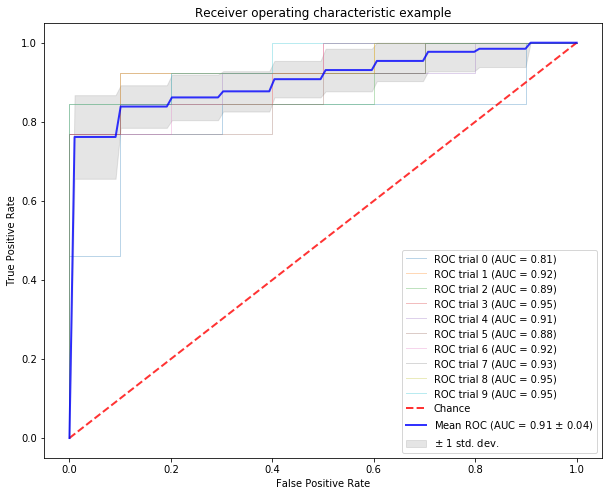

In [30]:
accuracies = []
balanced_accuracies = []
sensitivities = []
specificities = []
auc_scores = []
tprs = []
mean_fpr = np.linspace(0, 1, 100)

plt.figure(figsize=(10, 8))

for fold, weight in enumerate(weights):
    print("Fold {}".format(fold))
    model = load_model(model_path)
    model_dir = os.path.join(result_dir, weight)
    model.load_weights(model_dir)
    
    opti = Adam(lr=lr, decay=lr_decay)
    model.compile(optimizer=opti,
              loss='binary_crossentropy',
              metrics=['accuracy'])
    
    # Evaluate
    res = model.evaluate_generator(test_loader)
    y_pred = model.predict_generator(test_loader)
    bal_acc = balanced_accuracy(y_holdout, y_pred>0.5)
    sens = sensitivity(y_holdout, y_pred>0.5)
    spec = specificity(y_holdout, y_pred>0.5)
    roc_auc = roc_auc_score(y_holdout, y_pred)
    fpr, tpr, thresholds = roc_curve(y_holdout, y_pred)   
    # Store results
    accuracies.append(res[1])
    balanced_accuracies.append(bal_acc)
    sensitivities.append(sens)
    specificities.append(spec)
    auc_scores.append(roc_auc)
    tprs.append(interp(mean_fpr, fpr, tpr))
    tprs[-1][0] = 0.0
    # Print results
    print("Model accuracy {:.2f} %".format(res[1]*100))
    print("Balanced accuracy {:.2f} %".format(bal_acc*100))
    print("Sensitivity {:.2f} %".format(sens*100))
    print("Specificity {:.2f} %".format(spec*100))
    print("Area Under the Receiver Operating Curve (ROC AUC score) {:.2f}".format(roc_auc*100))
    plt.plot(fpr, tpr, lw=1, alpha=0.3,
             label='ROC trial %d (AUC = %0.2f)' % (fold, roc_auc))
    
print("######## Final results ########")
print("Accuracy mean {:.2f} %".format(np.mean(accuracies)*100))
print("Balanced accuracy mean {:.2f} %".format(np.mean(balanced_accuracies)*100))
print("Sensitivity mean {:.2f} %".format(np.mean(sensitivities)*100))
print("Specificity mean {:.2f} %".format(np.mean(specificities)*100))
print("Mean ROC AUC score {:.2f}".format(np.mean(auc_scores)*100))

# Plot ROC Curves
plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r',
         label='Chance', alpha=.8)

mean_tpr = np.mean(tprs, axis=0)
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)
#assert(mean_auc == np.mean(auc_scores))
std_auc = np.std(auc_scores)
plt.plot(mean_fpr, mean_tpr, color='b',
         label=r'Mean ROC (AUC = %0.2f $\pm$ %0.2f)' % (np.mean(auc_scores), std_auc),
         lw=2, alpha=.8)

std_tpr = np.std(tprs, axis=0)
tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
plt.fill_between(mean_fpr, tprs_lower, tprs_upper, color='grey', alpha=.2,
                 label=r'$\pm$ 1 std. dev.')

plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

In [31]:
total_time = time.time() - start_time

In [32]:
print("Training Time: {}h:{}m:{}s".format(
            training_time//3600, (training_time//60)%60, training_time%60))
print("Total time elapsed: {}h:{}m:{}s".format(
            total_time//3600, (total_time//60)%60, total_time%60))

Training Time: 1.0h:16.0m:19.69180130958557s
Total time elapsed: 1.0h:17.0m:51.91928458213806s


In [33]:
quit()